In [1]:
%load_ext lab_black

In [2]:
import sys

sys.path.append("..")
from gpjax import Prior, SpectralRBF, Gaussian, ZeroMean
import jax
import jax.numpy as jnp
import jax.random as jr
import objax
import numpy as onp
import matplotlib.pyplot as plt

key = jr.PRNGKey(123)

In [16]:
N = 100
noise = 0.1
M = 20

X = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
# X = X.sort()
f = lambda x: jnp.greater(x, 0)
signal = f(X)
y = signal + jr.normal(key, shape=signal.shape) * noise
Xtest = jnp.linspace(-3.0, 3.0, 500).reshape(-1, 1)
ytest = f(Xtest)

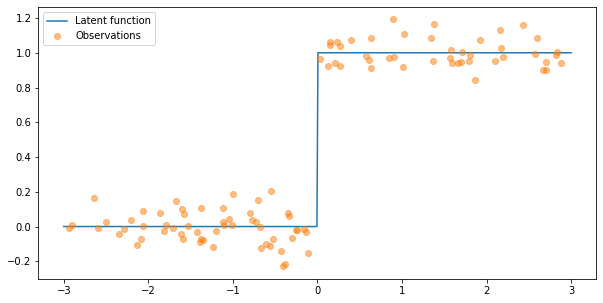

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Xtest, ytest, label="Latent function")
ax.plot(X, y, "o", label="Observations", alpha=0.5)
ax.legend(loc="best")
# plt.savefig("data.png")

In [18]:
kernel = SpectralRBF(
    num_basis=M, lengthscale=jnp.array([1.0]), variance=jnp.array([1.0])
)
meanf = ZeroMean()

prior = Prior(kernel=kernel, mean_function=meanf, jitter=1e-4)

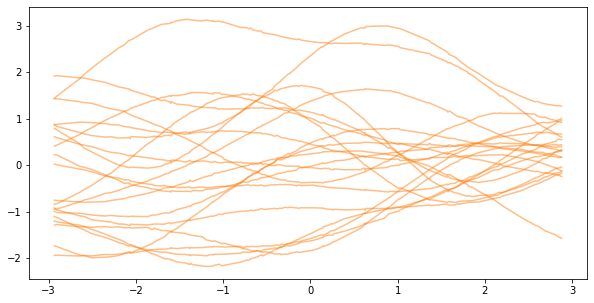

In [19]:
samples = prior.sample(X, key, n_samples=20)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, samples.T, color="tab:orange", alpha=0.5)
plt.show()

In [20]:
posterior = prior * Gaussian()

In [21]:
posterior.neg_mll(X, y)

DeviceArray(434.76394355, dtype=float64)

In [22]:
opt = objax.optimizer.Adam(posterior.vars())
gv = objax.GradValues(posterior.neg_mll, posterior.vars())

In [23]:
def train_op(x, label):
    g, v = gv(x, label)
    opt(0.01, g)
    return v


train_op = objax.Jit(train_op, gv.vars() + opt.vars())

In [24]:
nits = 250
loss = [train_op(X, y)[0].item() for _ in range(nits)]

Text(0.5, 0, 'Optimsation step number')

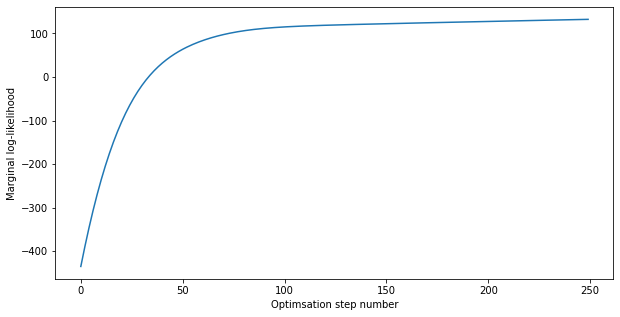

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([-l for l in loss])
ax.set_ylabel("Marginal log-likelihood")
ax.set_xlabel("Optimsation step number")

In [26]:
mu, cov = posterior.predict(Xtest, X, y)

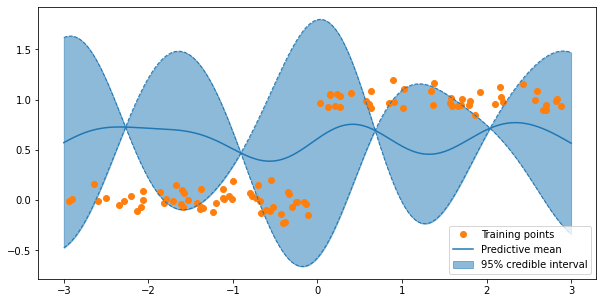

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, y, "o", label="Training points", color="tab:orange")
ax.plot(Xtest, mu, label="Predictive mean", color="tab:blue")
ax.fill_between(
    Xtest.ravel(),
    mu.squeeze() - 1.96 * cov,
    mu.squeeze() + 1.96 * cov,
    alpha=0.5,
    label="95% credible interval",
    color="tab:blue",
)
ax.plot(
    Xtest,
    mu.ravel() + 1.96 * cov,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    Xtest,
    mu.ravel() - 1.96 * cov,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.legend(loc="best")
# plt.savefig("predictive_posterior.png")

In [43]:
for k, v in posterior.vars().items():
    print(k, v.untransform)

(SpectralPosterior).kernel(SpectralRBF).lengthscale [0.57024587]
(SpectralPosterior).kernel(SpectralRBF).variance [0.65787377]
(SpectralPosterior).kernel(SpectralRBF).features [[ 2.34738707e+00]
 [-6.38977799e-08]
 [-1.81549933e+00]
 [ 1.02995274e+00]
 [-1.08564874e+00]
 [ 3.69423854e-07]
 [ 1.12483742e+00]
 [-1.29808144e+00]
 [ 9.74744610e-08]
 [ 1.14599251e+00]
 [-1.13690390e+00]
 [ 1.18578742e+00]
 [-1.13948257e+00]
 [ 1.28607984e+00]
 [-1.14523810e+00]
 [ 1.16114735e+00]
 [-1.39947506e+00]
 [-1.15354321e+00]
 [-1.27693925e+00]
 [-1.16137169e+00]]
(SpectralPosterior).likelihood(Gaussian).noise [1.55150968]
